Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Example images from our dataset:


<Figure size 640x480 with 0 Axes>

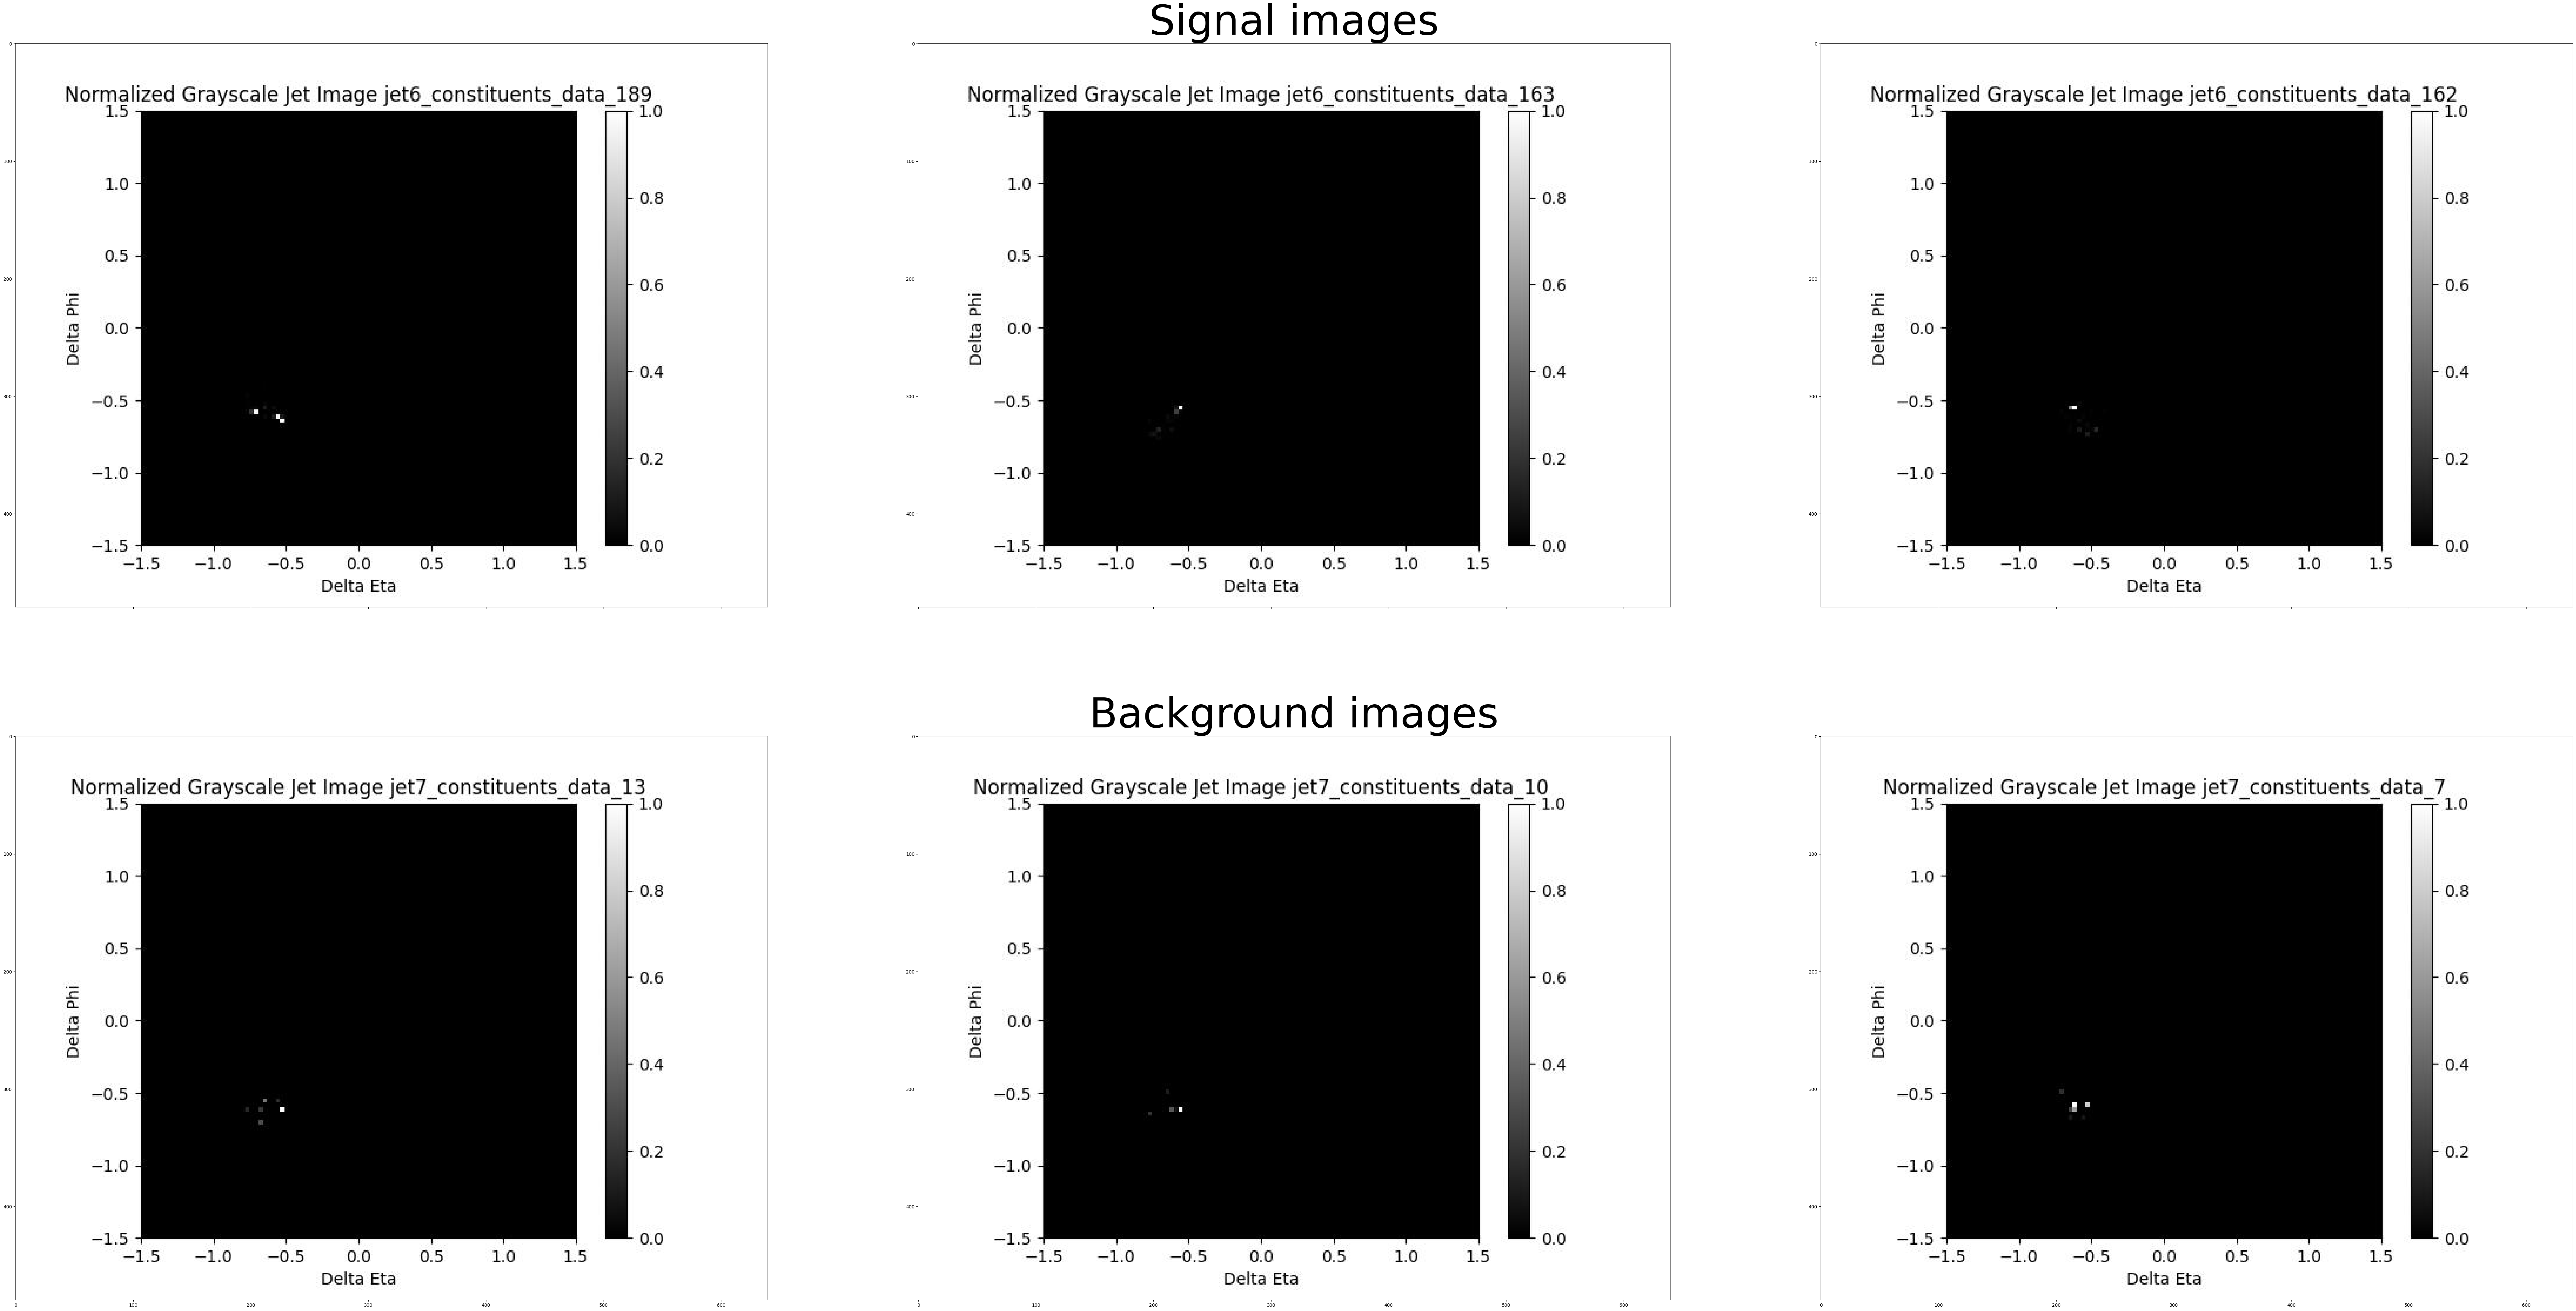

In [1]:
#DISPLAYING SOME REFERENCE IMAGES FROM DATASET

from PIL import Image
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
plt.figure()
fig, ax = plt.subplots(2,3,figsize=(100,50), sharex=True)

for i in range(4):
    folder="/content/drive/MyDrive/grey/signal"
    filename= os.listdir(folder)[i]
    f=os.path.join(folder, filename)
    im= Image.open(f)
    ax[0,i-1].imshow(im, cmap='gray')
for i in range(4):
    folder="/content/drive/MyDrive/grey/background"
    filename= os.listdir(folder)[i]
    f=os.path.join(folder, filename)
    im= Image.open(f)
    ax[1,i-1].imshow(im, cmap='gray')
print("Example images from our dataset:")
ax[0, 1].set_title("Signal images",fontsize = 90)
ax[1, 1].set_title("Background images",fontsize = 90)
plt.show()





In [2]:
#IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from PIL import Image
import math


In [3]:
#FUNCTION TO DISPLAY IMAGES IN THE OUTPUT FOR COMPARISON LATER

def DISPLAY(path1,path2):
    plt.figure()
    fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True)
    fig.suptitle('Wrong classification:')
    im1= Image.open(path1)
    im2=Image.open(path2)
    ax[0].imshow(im1, cmap='gray')
    ax[1].imshow(im2, cmap='gray')



In [5]:
#FUNCTION TO COLLECT IMAGE OBJECTS AND THEIR LABELS FROM DIRECTORY AS NUMPY ARRAYS FOR LATER USE
#LOADING ALL IMAGES FROM DRIVE

def get_images(folder,i):
    images = []
    names=[]
    labels=[]
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img=img.flatten()
        if img is not None:
            images.append(img)
            names.append(filename)
            labels.append(os.listdir('/content/drive/MyDrive/grey')[i])
    return images, names, labels

signal, s_names, s_label = get_images('/content/drive/MyDrive/grey/signal',1)
bg, bg_names, bg_label = get_images('/content/drive/MyDrive/grey/background',0)
images=signal+bg
labels= s_label+bg_label
images = np.array(images, 'uint8')
labels = np.array(labels)
print('Total number of images:', len(images))
print('Number of background images:', len(bg_label))
print('Number of signal images:', len(s_label))
print('Each image after flattening is of the shape:', images[1].shape)

Total number of images: 254
Number of background images: 100
Number of signal images: 154
Each image after flattening is of the shape: (921600,)


In [6]:
# SPLITTING ALL OF THE DATA INTO 80% TRAINING DATA - 20% TEST DATA

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=1)

In [7]:
#EIGENFACE MODEL: CALCULATING OPTIMAL W (EIGENVECTORS)

def Eigenface_model(images_train, labels_train):

    #subtracting mean face from all faces

    org=images_train
    images_train = images_train.T
    mean = images_train.mean(axis=1, keepdims=True)
    images_train = images_train - mean

    #computing covariance matrix (Total Scatter matrix)

    cov = np.matmul(np.transpose(images_train), images_train)

    #getting the eigen values and eigen vectors for Scatter matrix

    eigval, eigv = np.linalg.eig(cov)

    #getting corresponding eigen vectors
    eigu = np.matmul(images_train, eigv.real)

    #normalizing eigen vectors by dividing by root(Eigenvalue*Number of images)

    a=np.reciprocal(eigval)
    a=np.sqrt(a)
    eigu=np.multiply(eigu,a)
    eigu=1/math.sqrt(len(images_train))*eigu


    #arranging eigen values and hence eigen vecs in descending order of eigen values TO GET m LARGEST VALUES LATER

    idx = np.argsort(-eigval)
    eigval = eigval[idx]
    eigu = eigu[:, idx]


    return eigval, eigu, mean, org

In [8]:
#APPLYING THE ALGORITHM ON TEST IMAGES AND DISPLAYING RESULTS

def Eigenface_test(images_test, labels_test, labels_train, weights, mbest, mean):

    #Normalizing the test images

    images_test = images_test.T- mean
    labels_test = labels_test.T

    #calculating projected test images

    testweights = np.matmul(mbest.T, images_test)
    correct=0

    for i in range(0, len(labels_test)):

        #calculating sum of square of error error for each test image (FOR DISTANCE FROM CLASSES)

        testweight = np.resize(testweights[:, i], (testweights.shape[0], 1))
        err = (weights - testweight) ** 2
        ssq1 = np.sum(err ** (1/2), axis=0)


        #Finding the closest face to the test image (MINIMUM SSQ)

        dist= ssq1.min(axis=0, keepdims=True)
        match=labels_train[ssq1.argmin(axis=0)]

        #Checking if results are correct and Printing the result for this image
        if dist < 100:
            if labels_test[i] == match:
                correct+=1
                print("image of class %s identified correctly as %s with distance %f"
                      %(labels_test[i], match, dist.real))

            else:

                print ("image of class %s identified incorrectly as %s with distance %f"
                       %(labels_test[i], match, dist.real))

        else:
            print ("image not match in database :")


    print("\n THE FINAL ACCURACY OF EIGENFACES IS %f PERCENT"
          % (correct*100 / len(labels_test)))
    return


In [9]:
#MAIN PROGRAM:
#Performing Eigenface analysis and get Eigenface vectors

eigval, eigu, mean, org= Eigenface_model(images_train, labels_train)


# #Finding m best eigen vectors for dimension reduction to m dimensions

sum1 = np.sum(eigval, axis=0)
k = 0
for m in range(0, len(labels_train)):
    k += eigval[m] / sum1
    if k > 0.95:
        break
kbest = eigu[:, 0:m]

#Getting the projections of the of eigenfaces for each input image

weights = np.matmul(kbest.T, images_train.T- mean)


In [10]:
#Testing the Eigenface model on the test images and print the result

Eigenface_test(images_test, labels_test, labels_train, weights, kbest, mean)



image of class background identified incorrectly as signal with distance 1.828993
image of class signal identified correctly as signal with distance 3.165987
image of class signal identified correctly as signal with distance 4.633793
image of class signal identified correctly as signal with distance 3.084221
image of class background identified correctly as background with distance 4.028258
image of class signal identified correctly as signal with distance 4.556372
image of class background identified correctly as background with distance 4.013959
image of class signal identified correctly as signal with distance 2.892167
image of class signal identified correctly as signal with distance 3.309186
image of class background identified correctly as background with distance 2.021607
image of class signal identified correctly as signal with distance 4.863647
image of class background identified correctly as background with distance 2.918597
image of class background identified correctly as 